In [2]:
from modsim import *
from pint import UnitRegistry
units = UnitRegistry()

In [3]:
feet_to_meter = (1 * units.feet).to(units.meter).magnitude

In [4]:
params = Params(
    x=0, # m
    y=1, # m
    angle=45, # degree
    speed=40, # m / s

    mass=145e-3, # kg
    diameter=73e-3, # m
    C_d=0.33, # dimensionless

    rho=1.2, # kg/m**3
    g=9.8, # m/s**2
    t_end=10, # s

    wall_distance= 310 * feet_to_meter, # m
    wall_height= 37 * feet_to_meter, # m
)
params

namespace(x=0,
          y=1,
          angle=45,
          speed=40,
          mass=0.145,
          diameter=0.073,
          C_d=0.33,
          rho=1.2,
          g=9.8,
          t_end=10,
          wall_distance=94.48799999999999,
          wall_height=11.277599999999998)

In [17]:
from numpy import pi, deg2rad
def make_system(params):
    # convert angle to radians
    theta = deg2rad(params.angle)

    # compute x and y components of velocity
    vx, vy = pol2cart(theta, params.speed)

    # make the initial state
    init = State(x=params.x, y=params.y, vx=vx, vy=vy)

    # compute the frontal area
    area = pi * (params.diameter/2)**2

    # return system
    return System(params, init=init, area=area)

def drag_force(V, system):
    rho, C_d, area = system.rho, system.C_d, system.area
    mag = rho * vector_mag(V)**2 * C_d * area / 2
    direction = -vector_hat(V)
    f_drag = mag * direction
    return f_drag

def slope_func(t, state, system):
    x, y, vx, vy = state
    mass, g = system.mass, system.g
    V = Vector(vx, vy)
    a_drag = drag_force(V, system) / system.mass
    a_grav = Vector(0, -g)
    A = a_grav + a_drag
    return V.x, V.y, A.x, A.y

def event_func(t, state, system):
    x, y, vx, vy = state
    return y

system = make_system(params)

In [7]:
def range_func(angle, params):
    params = params.set(angle=angle)
    system = make_system(params)
    results, details = run_solve_ivp(system, slope_func, events=event_func)
    x_dist = results.iloc[-1].x
    print(angle, x_dist)
    return x_dist

In [8]:
range_func(45, params)

45 99.31829628352207


np.float64(99.31829628352207)

20.0 78.09741067882733
23.0 84.11542610650983
26.0 89.13192412363966
29.0 93.17466724082834
32.0 96.27134737391354
35.0 98.44725560273994
38.0 99.72474586365274
41.0 100.12347299697635
44.0 99.66100302635328
47.0 98.35354763684825
50.0 96.21673516565134
53.0 93.26623796736267
56.0 89.51751617672977
59.0 84.98724481958087
62.0 79.69434524339994
65.0 73.66129770133256
68.0 66.91470886279748
71.0 59.482694929397475
74.0 51.402871099404315
77.0 42.72047925533483
80.0 33.48437980813934


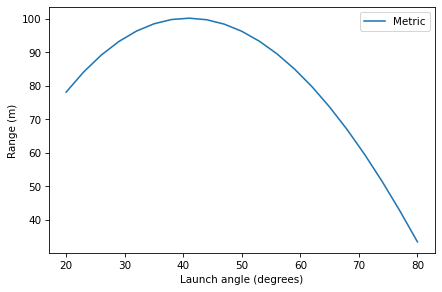

In [11]:
angles = linspace(20, 80, 21)
sweep = SweepSeries()
for angle in angles:
    x_dist = range_func(angle, params)
    sweep[angle] = x_dist
sweep.plot()
decorate(xlabel='Launch angle (degrees)',
         ylabel='Range (m)')

In [12]:
res = maximize_scalar(range_func, params, bounds=[0, 90])

0 17.468795355645696
34.37694101250946 98.06996498016366
55.62305898749054 90.03182421721928
21.246117974981075 80.72039493627986
41.173855871044005 100.1200188931698
40.980120907838035 100.12368377099199
40.882137319070246 100.1241700443184
40.87925420124324 100.12417043309694
40.87928713865314 100.12417043314977
40.879291078324286 100.12417043314917
40.879283198981994 100.12417043314895


In [13]:
res

 message: Solution found.
 success: True
  status: 0
     fun: 100.12417043314977
       x: 40.87928713865314
     nit: 10
    nfev: 10

In [14]:
res.x, res.fun

(np.float64(40.87928713865314), np.float64(100.12417043314977))

### Exercise 1

Let's finish off the Manny Ramirez problem:

> What is the minimum effort required to hit a home run in Fenway Park?

Although the problem asks for a minimum, it is not an optimization problem.  Rather, we want to solve for the initial speed that just barely gets the ball to the top of the wall, given that it is launched at the optimal angle.

And we have to be careful about what we mean by "optimal".  For this problem, we don't want the longest range; we want the maximum height at the point where it reaches the wall.

If you are ready to solve the problem on your own, go ahead.  Otherwise I will walk you through the process with an outline and some starter code.

As a first step, write an `event_func` that stops the simulation when the ball reaches the wall at `wall_distance`, which is a parameter in `params`.
Test your function with the initial conditions.

In [23]:
def event_func(t, state, system):
    x, y, vx, vy = state
    return x - system.wall_distance 

In [24]:
event_func(0, system.init, system)

-94.48799999999999

Next, write a function called `height_func` that takes a launch angle, simulates the flight of a baseball, and returns the height of the baseball when it reaches the wall.
Test your function with the initial conditions.

In [25]:
def height_func(angle, params):
    params = params.set(angle=angle)
    system = make_system(params)
    results, details = run_solve_ivp(system, slope_func, events=event_func)
    y_height = results.iloc[-1].y
    return y_height

In [26]:
height_func(45, params)

np.float64(6.968278259866757)

Now use `maximize_scalar` to find the optimal angle.  Is it higher or lower than the angle that maximizes range?

In [27]:
res2 = maximize_scalar(height_func, params, bounds=[0, 90])
res2

 message: Solution found.
 success: True
  status: 0
     fun: 7.217049532932929
       x: 43.1050809786475
     nit: 13
    nfev: 13

In [31]:
res2.x, res2.fun - system.wall_height

(np.float64(43.1050809786475), np.float64(-4.060550467067069))

The angle that maximizes the height at the wall is a little higher than the angle that maximizes range.

Now, let's find the initial speed that makes the height at the wall exactly 37 feet, given that it's launched at the optimal angle. 
This is a root-finding problem, so we'll use `root_scalar`.

Write an error function that takes a speed and a `System` object as parameters.  It should use `maximize_scalar` to find the highest possible height of the ball at the wall, for the given speed.  Then it should return the difference between that optimal height and `wall_height`, which is a parameter in `params`.

In [36]:
def error_func(speed, params):
    params = params.set(speed=speed, angle=res2.x)
    res = maximize_scalar(height_func, params, bounds=[0, 90])
    y_height = res.fun
    return y_height - params.wall_height

Test your error function before you call `root_scalar`.

In [37]:
error_func(system.speed, params)

np.float64(-4.060550467067069)

Then use `root_scalar` to find the answer to the problem, the minimum speed that gets the ball out of the park.

In [38]:
res3 = root_scalar(error_func, params, bracket=[30, 50])
res3

      converged: True
           flag: converged
 function_calls: 6
     iterations: 5
           root: 41.03929463402887
         method: brentq

In [41]:
# Solution
print(f"Optimal launch angle {res2.x:.2f} degrees at speed: {res3.root:.2f}  m/s")

Optimal launch angle 43.11 degrees at speed: 41.04  m/s


And just to check, run `error_func` with the value you found.

In [42]:
error_func(res3.root, params)

np.float64(0.0010039392295819738)